# Postverdad — Dashboard base (sin vistas)

Este notebook consulta **directamente** las tablas (`articles`, `sources`) y hace:
- Derivación de `polarity_label` y `subjectivity_bucket` en **pandas**
- Métricas por medio/mes
- Matriz last30 (polarity × subjectivity_bucket)
- Gráficos con matplotlib

**Requisitos**
- Variables de entorno: `POSTGRES_HOST`, `POSTGRES_PORT`, `POSTGRES_DB`, `POSTGRES_USER`, `POSTGRES_PASSWORD`.


In [1]:
import os
import pandas as pd
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 20)

PG = {
    "host": os.getenv("POSTGRES_HOST", "localhost"),
    "port": int(os.getenv("POSTGRES_PORT", "5432")),
    "dbname": os.getenv("POSTGRES_DB", "postverdad"),
    "user": os.getenv("POSTGRES_USER", "postverdad"),
    "password": os.getenv("POSTGRES_PASSWORD", "postverdad"),
}
PG


{'host': 'localhost',
 'port': 5432,
 'dbname': 'postverdad',
 'user': 'postverdad',
 'password': 'postverdad'}

In [2]:
def read_sql_df(query, params=None):
    conn = psycopg2.connect(**PG)
    try:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(query, params or {})
            rows = cur.fetchall()
        return pd.DataFrame(rows)
    finally:
        conn.close()

## 1) Cargar artículos + fuentes (limit 5000 para exploración)

In [3]:
q_articles = """
SELECT
  a.id, a.url, a.title, a.source_id, s.name AS source,
  a.publication_date, a.polarity, a.subjectivity
FROM articles a
LEFT JOIN sources s ON s.id = a.source_id
ORDER BY a.publication_date DESC NULLS LAST
LIMIT 5000;
"""
df = read_sql_df(q_articles)
display(df.head(10))
df.shape

,id,url,title,source_id,source,publication_date,polarity,subjectivity
0,1270,https://www.elmostrador.cl/revista-jengibre/ga...,La Caperucita y El Lobo: cocina de autor e ide...,2.0,el_mostrador,2025-12-08,1.0,0.0972
1,1263,https://www.elmostrador.cl/cultura/agenda/2025...,Carlos Cabezas en Teatro Municipal de Santiago,2.0,el_mostrador,2025-12-08,1.0,0.0771
2,1251,https://www.elmostrador.cl/cultura/ciencia-cul...,Restos de científico británico hallados en la ...,2.0,el_mostrador,2025-12-08,0.0,0.0612
3,1262,https://www.elmostrador.cl/noticias/opinion/ca...,La guerra contra los testigos,2.0,el_mostrador,2025-12-08,-1.0,0.0752
4,1261,https://www.elmostrador.cl/cultura/2025/08/12/...,Sinfónica presenta su primer programa familiar...,2.0,el_mostrador,2025-12-08,1.0,0.0589
5,1252,https://www.elmostrador.cl/noticias/opinion/co...,Reordenamiento de la red de alianzas en el Ind...,2.0,el_mostrador,2025-12-08,0.0,0.0887
6,1253,https://www.elmostrador.cl/noticias/pais/2025/...,Valparaíso: 14 nombres al Senado para 5 cupos ...,2.0,el_mostrador,2025-12-08,0.0,0.0584
7,1260,https://www.elmostrador.cl/cultura/critica-opi...,Ley Tommy Rey: que los intérpretes y ejecutant...,2.0,el_mostrador,2025-12-08,0.0,0.0709
8,1241,https://www.elmostrador.cl/agenda-pais/ninez/2...,Colecta digital 2025 para cumplir deseos de ni...,2.0,el_mostrador,2025-12-08,1.0,0.0791
9,1259,https://www.elmostrador.cl/noticias/mundo/2025...,Sube a 15 cifra de muertos por torrentes de mo...,2.0,el_mostrador,2025-12-08,-1.0,0.0736


(5000, 8)

## 2) Binning en pandas (polarity_label, subjectivity_bucket)

In [4]:
import numpy as np

def label_polarity_discrete(x):
    if pd.isna(x): return 'not_calculated'
    if x == -1: return 'negative'
    if x ==  0: return 'neutral'
    if x ==  1: return 'positive'
    return 'other'

def bucket_subjectivity(x):
    if pd.isna(x): return 'not_calculated'
    if x <= 0.15: return 'low'      # 0.00–0.15
    if x <= 0.35: return 'medium'   # 0.16–0.35
    return 'high'                   # 0.36–1.00

df['polarity_label'] = df['polarity'].apply(label_polarity_discrete)
df['subjectivity_bucket'] = df['subjectivity'].apply(bucket_subjectivity)

display(df[['id','source','publication_date','polarity','polarity_label','subjectivity','subjectivity_bucket']].head(10))

,id,source,publication_date,polarity,polarity_label,subjectivity,subjectivity_bucket
0,1270,el_mostrador,2025-12-08,1.0,positive,0.0972,low
1,1263,el_mostrador,2025-12-08,1.0,positive,0.0771,low
2,1251,el_mostrador,2025-12-08,0.0,neutral,0.0612,low
3,1262,el_mostrador,2025-12-08,-1.0,negative,0.0752,low
4,1261,el_mostrador,2025-12-08,1.0,positive,0.0589,low
5,1252,el_mostrador,2025-12-08,0.0,neutral,0.0887,low
6,1253,el_mostrador,2025-12-08,0.0,neutral,0.0584,low
7,1260,el_mostrador,2025-12-08,0.0,neutral,0.0709,low
8,1241,el_mostrador,2025-12-08,1.0,positive,0.0791,low
9,1259,el_mostrador,2025-12-08,-1.0,negative,0.0736,low


## 3) Métricas por medio y mes (pandas)

In [5]:
df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
df['month'] = df['publication_date'].dt.to_period('M').dt.to_timestamp()

agg = (
    df.groupby(['source','month'])
      .agg(
          articles=('polarity', 'size'),
          pct_neg=('polarity_label', lambda s: 100 * (s=='negative').mean()),
          pct_neu=('polarity_label', lambda s: 100 * (s=='neutral').mean()),
          pct_pos=('polarity_label', lambda s: 100 * (s=='positive').mean()),
          avg_subjectivity=('subjectivity', 'mean'),
          pct_high_subjectivity=('subjectivity', lambda s: 100 * (s.ge(0.36)).mean(skipna=True))
      )
      .reset_index()
)

agg['avg_subjectivity'] = agg['avg_subjectivity'].round(3)
for col in ['pct_neg','pct_neu','pct_pos','pct_high_subjectivity']:
    agg[col] = agg[col].round(1)

display(agg.head(12))

,source,month,articles,pct_neg,pct_neu,pct_pos,avg_subjectivity,pct_high_subjectivity
0,Fuente Test,2025-07-01,1,0.0,0.0,0.0,NaN,0.0
1,Fuente Test,2025-09-01,1,0.0,0.0,0.0,0.600,100.0
2,el_mostrador,2025-06-01,535,30.7,48.4,20.9,0.079,0.0
3,el_mostrador,2025-07-01,1442,37.1,42.4,20.5,0.078,0.0
4,el_mostrador,2025-08-01,1425,36.1,42.1,21.8,0.077,0.0
5,el_mostrador,2025-09-01,393,37.2,40.2,22.6,0.077,0.0
6,el_mostrador,2025-10-01,411,39.4,38.0,22.6,0.077,0.0
7,el_mostrador,2025-11-01,405,43.2,37.0,19.8,0.076,0.0
8,el_mostrador,2025-12-01,386,35.2,43.8,21.0,0.077,0.0


## 4) Matriz polarity × subjectivity_bucket (últimos 30 días)

In [6]:
from datetime import datetime, timedelta
cutoff = pd.Timestamp.utcnow().tz_localize(None) - pd.Timedelta(days=30)
last30 = df[df['publication_date'] >= cutoff]

matrix = (
    last30.groupby(['polarity_label','subjectivity_bucket'])
          .size()
          .rename('n')
          .reset_index()
          .sort_values(['polarity_label','subjectivity_bucket'])
)

display(matrix)

,polarity_label,subjectivity_bucket,n
0,negative,low,1017
1,negative,medium,1
2,neutral,low,1108
3,other,high,1
4,positive,low,588
5,positive,medium,1


## 5) Gráficos (matplotlib)

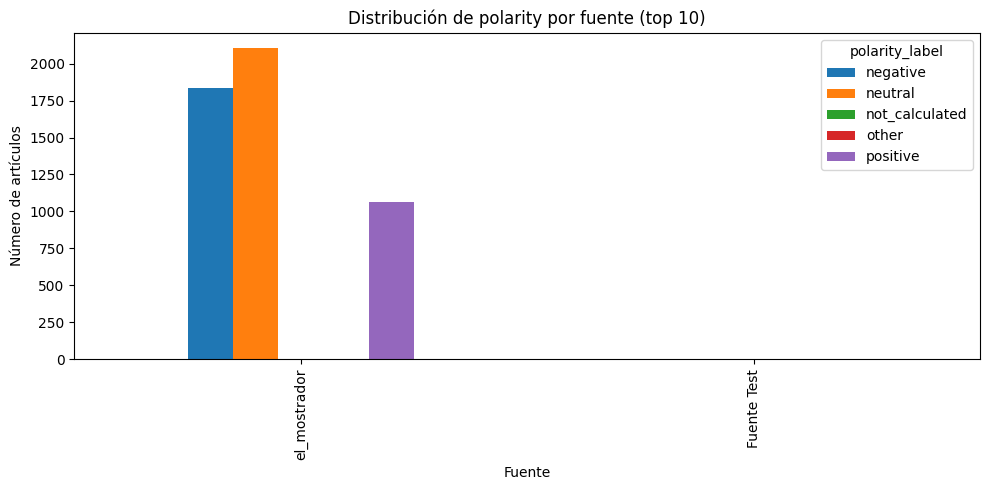

In [7]:
# Distribución de polarity por fuente (top 10 por volumen)
top_sources = (
    df['source'].value_counts()
      .head(10)
      .index
)
sub = df[df['source'].isin(top_sources)]
plot_data = (
    sub.groupby(['source','polarity_label'])
       .size()
       .unstack(fill_value=0)
       .reindex(top_sources)
)

ax = plot_data.plot(kind='bar', figsize=(10,5))
ax.set_title('Distribución de polarity por fuente (top 10)')
ax.set_xlabel('Fuente')
ax.set_ylabel('Número de artículos')
plt.tight_layout()
plt.show()

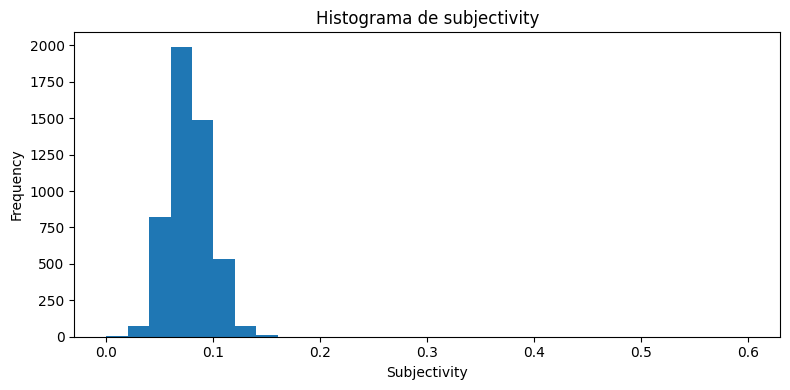

In [8]:
# Histograma de subjetividad
ax2 = df['subjectivity'].dropna().plot(kind='hist', bins=30, figsize=(8,4))
ax2.set_title('Histograma de subjectivity')
ax2.set_xlabel('Subjectivity')
plt.tight_layout()
plt.show()

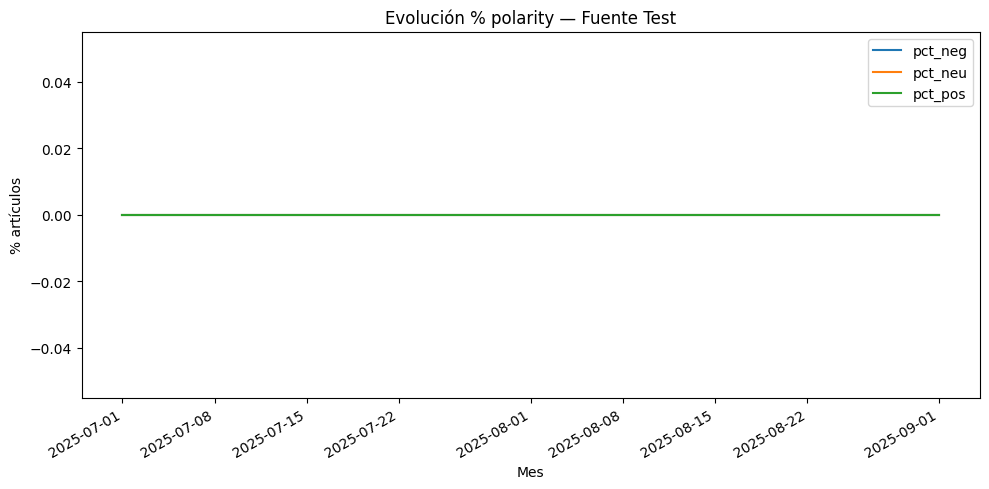

In [9]:
# Evolución mensual por fuente (ejemplo con primera fuente disponible)
if not agg.empty:
    fuente = agg['source'].iloc[0]
    dm = agg[agg['source'] == fuente].sort_values('month')
    ax3 = dm.set_index('month')[['pct_neg','pct_neu','pct_pos']].plot(figsize=(10,5))
    ax3.set_title(f'Evolución % polarity — {fuente}')
    ax3.set_xlabel('Mes')
    ax3.set_ylabel('% artículos')
    plt.tight_layout()
    plt.show()